# Shrinkage Methods
Shrinkage methods aim to decrease prediction error by introducing a bias that shrinks the coefficients obtained using OLS. This is achieved by minimizing RSS plus a penalty term. Being less fit to the training data, the model has bias but less variance among different possible training sets. OLS has low bias because it is fit to the data, but high variance because it will be fit to whatever sample is used.

The most basic shrinkage methods are ridge and lasso regression.


## Ridge Regression

Recall that OLS minimizes RSS. Ridge minimizes RSS plus a lambda parameter times the sum of the squares of the coefficients. Here is how that looks:

$$\text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2$$

Note that the intercept is not included in the penalty term and that $\lambda \ge 0$. Lambda has to be tuned separately. When $\lambda = 0$, ridge regression is equivalent to OLS. As $\lambda$ approaches infinity, the coefficients approach 0.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Data

It is important to note that the inputs for ridge regression are generally standardized. With multiple features of different scales, the penalty would otherwise not have a uniform effect. If standardized (or centered), the intercept will be $\bar{y}$. In the case of one feature with a coefficient approaching 0, $\bar{y}$ would minimize the residuals.

The rest of the coefficients follow a similar form to OLS:

$$\hat{\beta}_{ridge} =(X^TX + \lambda I)^{-1} X^{T}y$$

In [98]:
train_df = pd.read_pickle('Data/prostate.pkl').query("train == 'T'")
test_df = pd.read_pickle('Data/prostate.pkl').query("train == 'F'")
features = train_df.columns.to_list()
features = [item for item in features if item not in ['lpsa', 'train']]

In [99]:
X = train_df[features]  # No intercept columns
y = np.array(train_df['lpsa'])

beta_0 = y.mean()

l = 20  # Placeholder lambda
id_mat = np.identity(len(features))  # p * p identity matrix
beta = np.linalg.inv((X.T @ X) + (l * id_mat)) @ (X.T @ y)

np.append(beta_0, beta)

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

## Statsmodels and SciKit-Learn

Using Statsmodels for ridge regression is a little more annoying, which is why I will also introduce SciKit-Learn. This will also show why it is important to understand how a library/package implements a model, what defaults it has, and what the inputs are.

Notes on Statsmodels:
The penalty term which is called alpha instead of lambda is applied to every term including the intercept which we don't want. Instead, we are able to pass a vector with the first term being 0. Lambda is also scaled by the number of data points, so for comparison we must divide by n. You don't normally have to do this since you would still be searching for what lambda works the best, but it is important to note.

In [100]:
# Statsmodels
# Same Patsy setup as before
rhs = 'lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45'
y, X = patsy.dmatrices(rhs, train_df)

# We still use OLS to build the model
linear_model = sm.regression.linear_model.OLS(y,X)

# Create the lambda array
lambdas = np.zeros(9)
lambdas[1:] = 20 / train_df.shape[0]

# fit_regularized instead of fit, supply lambda vector, and set L1_wt to 0 for ridge (1 is LASSO)
results = linear_model.fit_regularized(alpha=lambdas,L1_wt=0.0)

# .summary() is not implemented yet
results.params

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

In [101]:
# sklearn
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=20, fit_intercept=True)

X = train_df[features]
y = np.array(train_df['lpsa'])

ridge_reg.fit(X, y)  # Note X, y instead of y, X
np.append(ridge_reg.intercept_, ridge_reg.coef_)

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

Here's how the coefficients shrink as lambda increases:

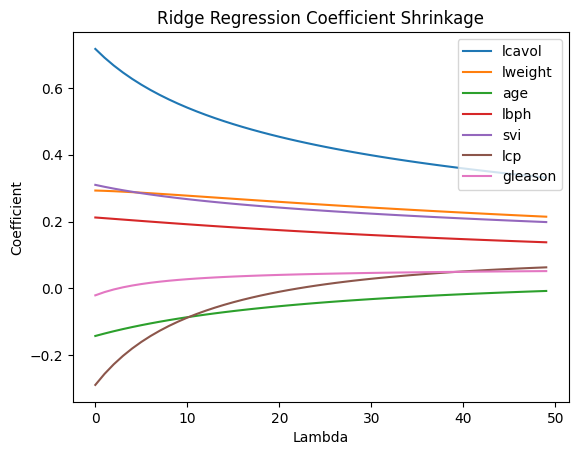

In [102]:
coeff_array = np.zeros((50,10))

for i in range(50):
    ridge_reg = Ridge(alpha=i, fit_intercept=True)
    ridge_reg.fit(X, y)
    coeff_array[i,:] = np.append(np.append(ridge_reg.intercept_, ridge_reg.coef_),i)
    
plt.plot(coeff_array[:,9], coeff_array[:,1:8])
plt.title('Ridge Regression Coefficient Shrinkage')
plt.ylabel('Coefficient')
plt.xlabel('Lambda')
plt.legend(features);

## Lasso

Where the coefficient of less impactful features tend to 0 in ridge regression, lasso's penalty can set them to 0. Additionally instead of an L2-norm penalty term, lasso uses an L1-norm penalty. So we are minimizing:
$$\text{RSS} + \lambda \sum_{j=1}^{p} |\beta_j|$$ 

Because the absolute value is not differentiable, there is no closed form solution like there is for ridge and ols.

Note that StatsModel and SciKit-Learn use the same lambda (alpha), but we may see slightly different results based on the functions work.

In [103]:
# Statsmodels
# Same Patsy setup as before
rhs = 'lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45'
y, X = patsy.dmatrices(rhs, train_df)

# We still use OLS to build the model
linear_model = sm.regression.linear_model.OLS(y,X)

# Create the lambda array
lambdas = np.zeros(9)
lambdas[1:] = 10 / train_df.shape[0]

# fit_regularized instead of fit, supply lambda vector, and set L1_wt to 1 for LASSO
results = linear_model.fit_regularized(alpha=lambdas,L1_wt=1.0)

# .summary() is not implemented yet
results.params

array([2.45234509, 0.56899064, 0.21100748, 0.        , 0.05799238,
       0.13671977, 0.        , 0.        , 0.03503067])

In [104]:
# sklearn
from sklearn.linear_model import Lasso

l = 10 / train_df.shape[0]
lasso_reg = Lasso(alpha=l, fit_intercept=True)

X = train_df[features]
y = np.array(train_df['lpsa'])

lasso_reg.fit(X, y)  # Note X, y instead of y, X
np.append(lasso_reg.intercept_, lasso_reg.coef_)

array([2.45234509, 0.5689806 , 0.21100084, 0.        , 0.05799792,
       0.13672137, 0.        , 0.        , 0.03503541])